# i. Business Understanding

## i.i TopBank Company

* TopBank is a large banking services company. It operates mainly in European countries offering financial products, from bank accounts to investments, including some types of insurance and investment products.
* The company's main product is a bank account, in which the customer can deposit his salary, make withdrawals, deposits and transfer to other accounts. This bank account has no cost to the customer and is valid for 12 months, that is, the customer needs to renew the contract of that account to continue using it for the next 12 months.
* According to the TopBank Analytics team, each customer who owns this bank account returns a monetary value of 15% of the value of their estimated salary, if it is lower than the average and 20% if that salary is higher than the average, during the current period of your account. This value is calculated annually.

### i.i.i The problem to be solved

* In recent months, the Analytics team realized that the rate of customers canceling their accounts and leaving the bank, reached unprecedented numbers in the company. Concerned about the increase in this rate, the team devised an action plan to reduce the rate of customer evasion.

## i.ii The Challenge

Create a model that returns a customer base with one more column. This new column should show whether they can be churned or not.

### i.ii.i Business Questions

* What the currently Churn rate of the TopBank? 
* How does it varies monthly?
* Qual a Performance do modelo em classificar os clientes como churns?
* What is the expected return, in terms of revenue, if the company uses its model to avoid churn from customers?

A possible action to prevent the customer from churning is to offer a discount coupon, or some other financial incentive for him to renew his contract for another 12 months.

* Which customers would you give the financial incentive to and what would that amount be, in order to maximize ROI (Return on Investment). Recalling that the sum of incentives for each client cannot exceed R$ 10.000,00.

# 0.0 Imports & Functions

In [1]:
import boruta
import joblib
import warnings
import inflection

import numpy             as np
import pandas            as pd
import seaborn           as sns
import category_encoders as ce

import sklearn.metrics   as m
import matplotlib.pyplot as plt

from IPython.display      import Image
from IPython.core.display import HTML

from scipy    import stats
from boruta   import BorutaPy
from xgboost  import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm             import SVC
from sklearn.dummy           import DummyClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression

from sklearn.preprocessing   import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV 

## 0.1 Helper Funtions

In [2]:
seed = 42
np.random.seed(seed)

In [3]:
warnings.filterwarnings("ignore")

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [6]:
def getLifeStage(age):
    if age <= 3:
        life_stage = "Infancy"
    
    elif age > 3 and age <= 6:
        life_stage = "Early Childhood"
        
    elif age > 6 and age <= 8:
        life_stage = "Middle Childhood"
        
    elif age >= 9 and age <= 11:
        lige_stage = "Late Childhood"
        
    elif age >= 12 and age <= 20:
        life_stage = "Adolescence"
        
    elif age > 20 and age <= 35:
        life_stage = "Early Adulthood"
        
    elif age > 35 and age <= 50:
        life_stage = "Midlife"
        
    elif age > 50 and age <= 80:
        life_stage = "Mature Adulthood"
        
    else:
        life_stage = "Late Adulthood"
        
    return life_stage

In [7]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = m.balanced_accuracy_score(y_true, y_pred)
    precision = m.precision_score(y_true, y_pred)
    recall = m.recall_score(y_true, y_pred)
    f1 = m.f1_score(y_true, y_pred)
    kappa = m.cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, index=[model_name])

In [8]:
def calcCramerV(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [9]:
def ml_cv_results(model_name, model, X, y):

    '''initial'''
    X_ = X.to_numpy()
    y_ = y.to_numpy()
    
    mm = MinMaxScaler()
    
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []

    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(X_, y_):
       
        ## selecting train and test
        X_train, X_test = X.iloc[index_train], X.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        X_train_rescaled = mm.fit_transform(X_train)
        X_test_rescaled = mm.transform(X_test)
        
        ## training the model
        model.fit(X_train_rescaled, y_train)
        y_pred = model.predict(X_test_rescaled)

        ## saving the metrics
        balanced_accuracies.append(m.balanced_accuracy_score(y_test, y_pred))
        precisions.append(m.precision_score(y_test, y_pred))
        recalls.append(m.recall_score(y_test, y_pred))
        f1s.append(m.f1_score(y_test, y_pred))
        kappas.append(m.cohen_kappa_score(y_test, y_pred))
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

# 1.0 Data Description

## 1.1 Loading Data

In [10]:
df1 = pd.read_csv('../database/churn.csv')
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [11]:
df1.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


## 1.2 Columns

### 1.2.1 Columns Description

* **RowNumber:** The number of column.
* **CustomerID:** Customer's ID.
* **Surname:** Customer's last name.
* **CreditScore:** Customer credit score for the consumer market.
* **Geography:** The country where the customer lives.
* **Gender:** The customer gender.
* **Age:** The customer age.
* **Tenure:** Number of years that the customer has remained active.
* **Balance:** Monetary value that the customer has in their bank account.
* **NumOfProducts:** The number of products purchased by the customer at the bank.
* **HasCrCard:** It indicates whether the customer has a credit card or not.
* **IsActiveMember:** It indicates whether the customer has made at least one transaction in the bank account within 12 months.
* **EstimateSalary:** Estimated monthly salary of the client.
* **Exited:** It indicates whether the customer is in Churn or not.

### 1.2.2 Column Rename

In [12]:
cols_old = df1.columns.tolist()

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.3 Data Dimensions

In [13]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 10000
Number of Cols: 14


## 1.4 Data Types and Structure

In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   row_number        10000 non-null  int64  
 1   customer_id       10000 non-null  int64  
 2   surname           10000 non-null  object 
 3   credit_score      10000 non-null  int64  
 4   geography         10000 non-null  object 
 5   gender            10000 non-null  object 
 6   age               10000 non-null  int64  
 7   tenure            10000 non-null  int64  
 8   balance           10000 non-null  float64
 9   num_of_products   10000 non-null  int64  
 10  has_cr_card       10000 non-null  int64  
 11  is_active_member  10000 non-null  int64  
 12  estimated_salary  10000 non-null  float64
 13  exited            10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


## 1.5 Check NA

In [15]:
df1.isna().mean()

row_number          0.0
customer_id         0.0
surname             0.0
credit_score        0.0
geography           0.0
gender              0.0
age                 0.0
tenure              0.0
balance             0.0
num_of_products     0.0
has_cr_card         0.0
is_active_member    0.0
estimated_salary    0.0
exited              0.0
dtype: float64

## 1.6 Fillout NA

There's no Na values

## 1.7 Change Data Types

I will change the values 0 and 1 to 'yes' and 'no'. It'll help on the data description and analysis sections.

In [16]:
df1['exited'] = df1['exited'].map({1: 'yes', 0: 'no'})
df1['is_active_member'] = df1['is_active_member'].map({1: 'yes', 0: 'no'})
df1['has_cr_card'] = df1['has_cr_card'].map({1: 'yes', 0: 'no'})

## 1.8 Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes(exclude='object')
cat_attributes = df1.select_dtypes(include='object')

### 1.8.1 Numerical Atributes

In [18]:
num_attributes = num_attributes.drop(columns=['row_number', 'customer_id'], axis=1)

In [19]:
describe = num_attributes.describe().T

describe['range'] = (num_attributes.max() - num_attributes.min()).tolist()
describe['variation coefficient'] = (num_attributes.std() / num_attributes.mean()).tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
credit_score,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00,500.00,0.148577,-0.071607,-0.425726
age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00,74.00,0.269458,1.011320,1.395347
tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00,10.00,0.576958,0.010991,-1.165225
balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09,250898.09,0.815803,-0.141109,-1.489412
num_of_products,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00,3.00,0.380117,0.745568,0.582981
estimated_salary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48,199980.90,0.574586,0.002085,-1.181518


**credit_score**
* The variation coeficient is less than 15%, therefore it has a less dispersions.
* The values skew and kurtosis are close to 0, so it can look a normal distribution.

**age**
* The range is 74 years.
* The variation coeficient is greater than 15% but less than 30%.
* The skew and kurtosis values show that the peak is a little sharp and has a tendency to the right of the data. Mean > median > mode.

**Tenure**
* The data is more homogeneous, because the variation coefficient is less than 15%.
* The skew values are close to 0, so there is not much deviation. However, the kurtosis value is negative, which shows a deviation from the syrup on the left. mean < median < mode.

**Balance**
* The coefficient variation is about 80%, therefore the data isn't homogeneous.
* Skew and Kurtosis are negative. Skew value shows that the distribution is left shifted. Kurtosis shows that the distribution tends to a plateau.

**Estimated Salary**
* The variation coefficiente is greather than 0.5.
* It's more plane kurtosis is -0.5.

### 1.8.2 Categorical Atributes

In [20]:
cat_attributes['surname'].values

array(['Hargrave', 'Hill', 'Onio', ..., 'Liu', 'Sabbatini', 'Walker'],
      dtype=object)

There are so many surnames that it cannot be shown here. Also, I didn't find any generical surname like 'other'. It'll be importanto to select this feature for the model training.

In [21]:
cat_attributes['geography'].value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: geography, dtype: float64

In [22]:
cat_attributes['gender'].value_counts(normalize=True)

Male      0.5457
Female    0.4543
Name: gender, dtype: float64

In [23]:
cat_attributes['is_active_member'].value_counts(normalize=True)

yes    0.5151
no     0.4849
Name: is_active_member, dtype: float64

In [24]:
cat_attributes['exited'].value_counts(normalize=True)

no     0.7963
yes    0.2037
Name: exited, dtype: float64

# 2.0 Feature Engineering

In [25]:
df2 = df1.copy()

## 2.1 Mind Map

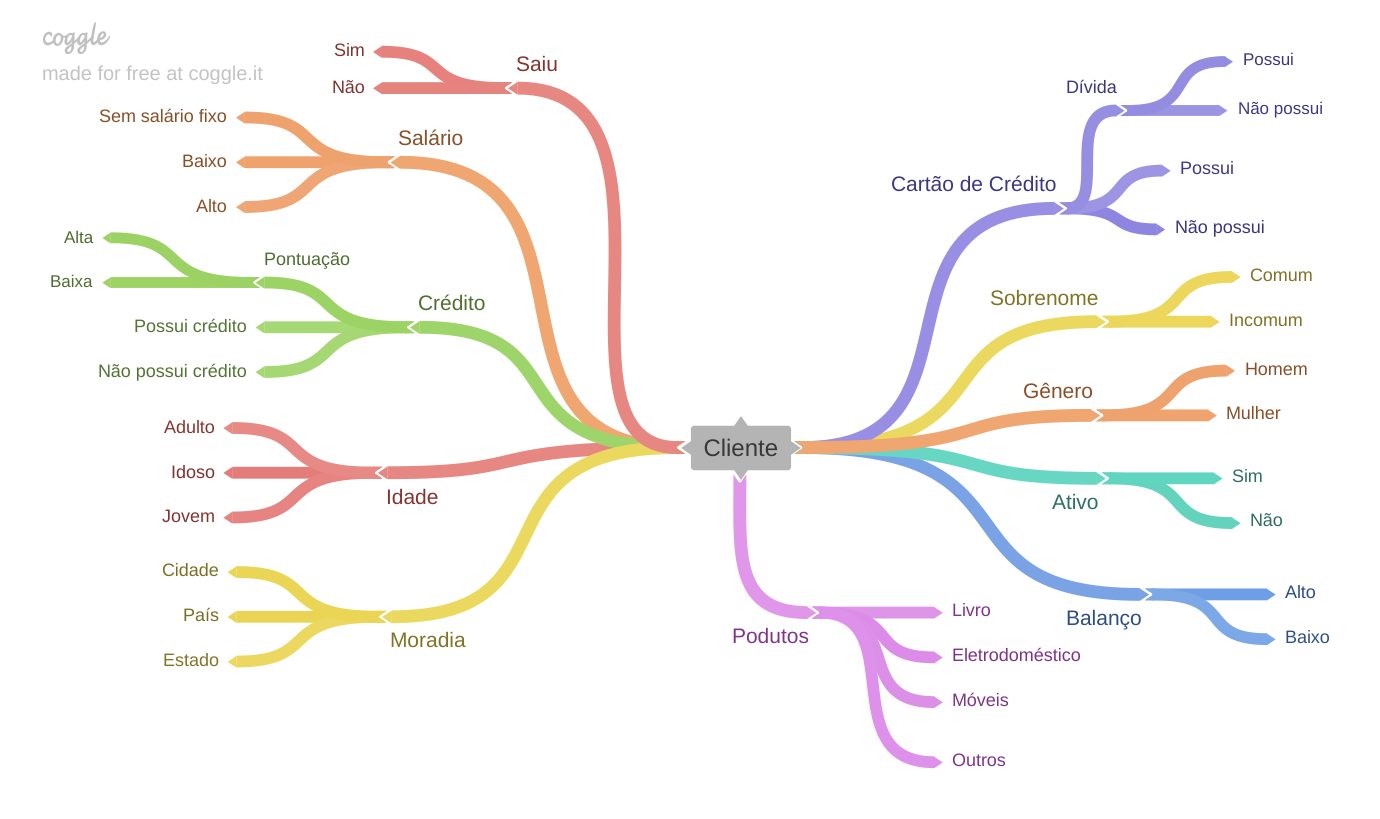

In [26]:
Image('../images/mindmap.png')

## 2.2 Creating Hypothesis

### 2.2.1 Gender

1. Há menos *churns* entre as mulheres.

1. Há mais mulheres ativas do que homens.

1. Há mais homens mais velhos em *churn*.

1. Homens mais jovens tem mais dívidas no cartão.

1. Mulheres possuem mais cartão de crédito.

1. Homens compram mais eletrodomésticos.

### 2.2.2 Active Member

1. Pessoas com cadastro ainda ativo têm menos *churn*.

1. Há pessoas jovens mais ativos do que mais velhos.

1. Clientes mais ativos gastam mais.

1. Clientes mais ativos possuem maiores créditos.

1. Clientes com salários mais altos são mais ativos.

1. Clientes com cartão de crédito são mais ativos.

1. Pessoas mais ativas compram mais produtos.

### 2.2.3 Credit Card

1. Pessoas com cartões com dívida são menos ativos.

1. Pessoas com maiores gastos possuem cartão de crédito.

1. Pessoas mais jovens que possuem cartão de crédito.

1. Pessoas de países mais ricos possuem cartão de crédito.

1. Pessoas com cartão de crédito gastam mais com a empresa.

### 2.2.4 Salary

1. Salários maiores compram mais.

1. Salários menores tem mais dívida no catão de crédito.

1. Salários menores têm menos crédito.

1. Países menos ricos têm os menores salários.

1. Jovens têm os menores salários.

1. Pessoas com os menores entram mais em *churn*

1. Pessoas com maiores salários estão mais ativos.

### 2.2.5 Exited

1. Pessoas mais jovens que entram em *churn*.

1. Pessoas com menos crédito que entram em *churn*

1. Os salários menores que estão mais em *churn*.

1. Cartões de crédito com dívidas estão em *churn*.

1. Pessoas que moram em países mais ricos entram menos em *churn*.

1. Pessoam que gastam menos entram em *churn*.

## 2.3 Final Hypothesis List

1. Pessoas com mais tempo ativo gastam mais.

1. Pessoas mais jovens que entram em *churn*.

1. Pessoas com menos crédito entram mais em *churn*.

1. Os salários menores estão mais em *churn*.

1. Pessoas que moram em países mais ricos entram menos em *churn*.

1. Pessoam que gastam menos entram em *churn*.

1. Pessoas com cartão de crédito gastam mais com a empresa.

1. Clientes com cartão de crédito são mais ativos.

1. Pessoas com maiores salários gastam mais.

1. Pessoas com maiores salários estão mais ativos.

1. Pessoas com mais crédito gastam mais.

## 2.3 Feature Engineering

### 2.3.1 Life Stage

In [27]:
df2['life_stage'] = df2['age'].apply(getLifeStage)

In [28]:
df2[['age', 'life_stage']].sample(5)

,age,life_stage
6252,32,Early Adulthood
4684,43,Midlife
1731,44,Midlife
4742,59,Mature Adulthood
4521,27,Early Adulthood


### 2.3.1 Richest Country

Usando esta [matéria](https://moneyinc.com/richest-countries-in-europe/) como referência eu selecionei eu coloquei os ranks dos países para saber se a renda percapta da população influência se a pessoa entra ou não em churn.

In [29]:
df2['ranked_richest_eu'] = df2['geography'].map({'France': 14, 'Spain': 16, 'Germany': 8})

In [30]:
df2[['geography', 'ranked_richest_eu']].sample(5)

,geography,ranked_richest_eu
6366,Germany,8
9628,France,14
5916,Spain,16
681,Spain,16
5459,Spain,16


# 3.0 Filtering Variables

In [31]:
df3 = df2.copy()

## 3.1 Filtering Lines

I will use every line, therefore I'll won't drop any line.

## 3.2 Filtering Columns

The columns row_number, custom_id and surname won't help the data analysis and the model learning. So I'll drop them.

In [32]:
df3 = df3.drop(columns=['row_number', 'customer_id', 'surname'], axis=1)

# 4.0 Exploratory Data Analysis

In [33]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

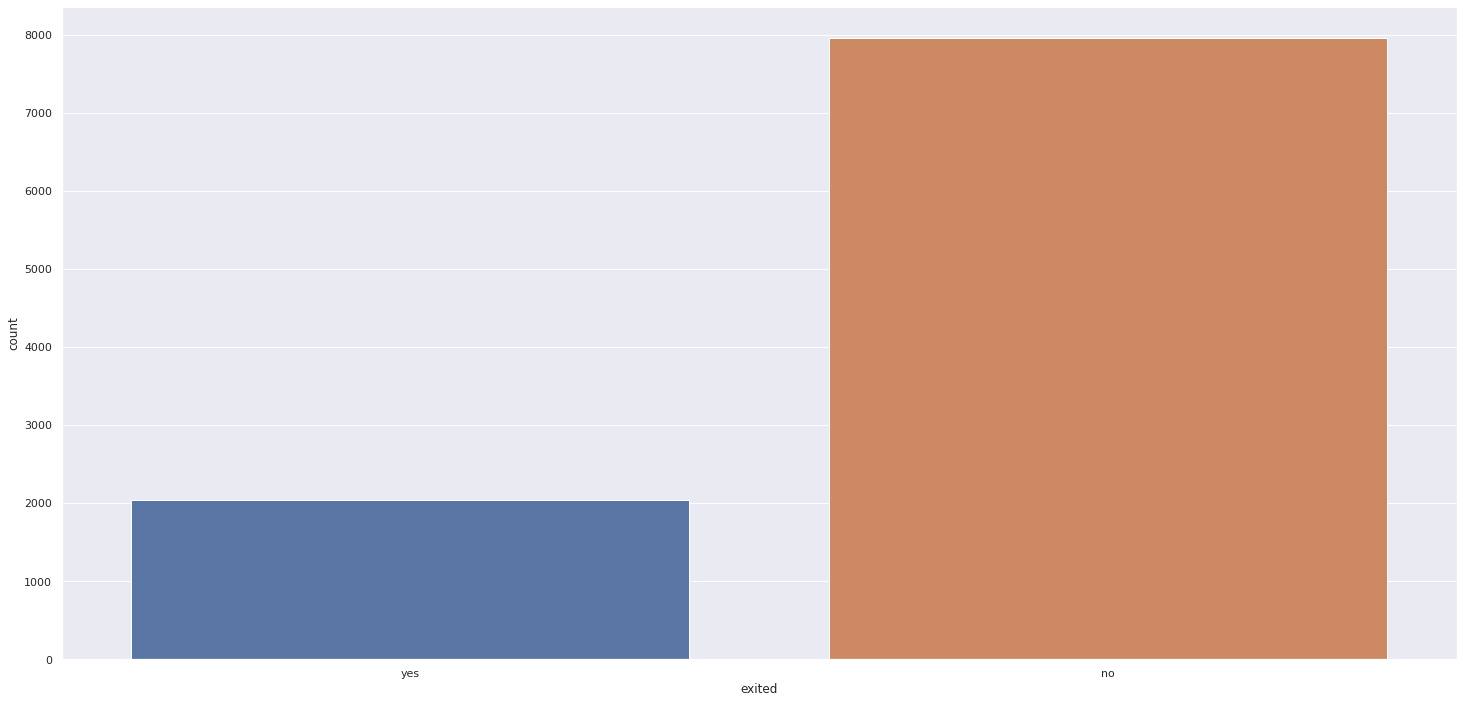

In [34]:
sns.countplot(x='exited', data=df4);

* There's a lot of 'no', so it's disbalanced database.
* 20% of 'yes' and 80% of 'no' churn.

### 4.1.2 Numerical Variables

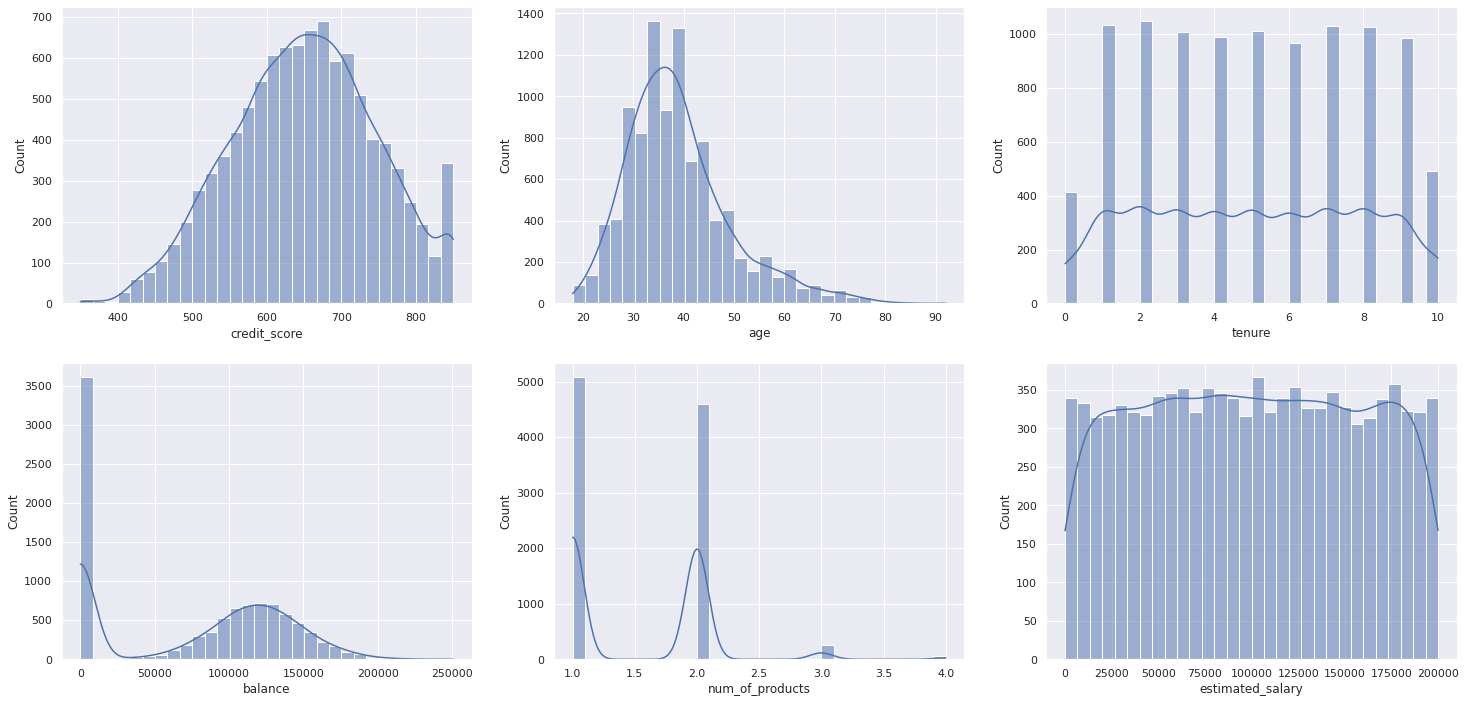

In [35]:
columns = num_attributes.columns;
j = 1

for i in columns:
    plt.subplot(2, 3, j)
    sns.histplot(x=i, data=df4, kde=True, bins=30);
    
    j += 1

### 4.1.3 Categorical Variables

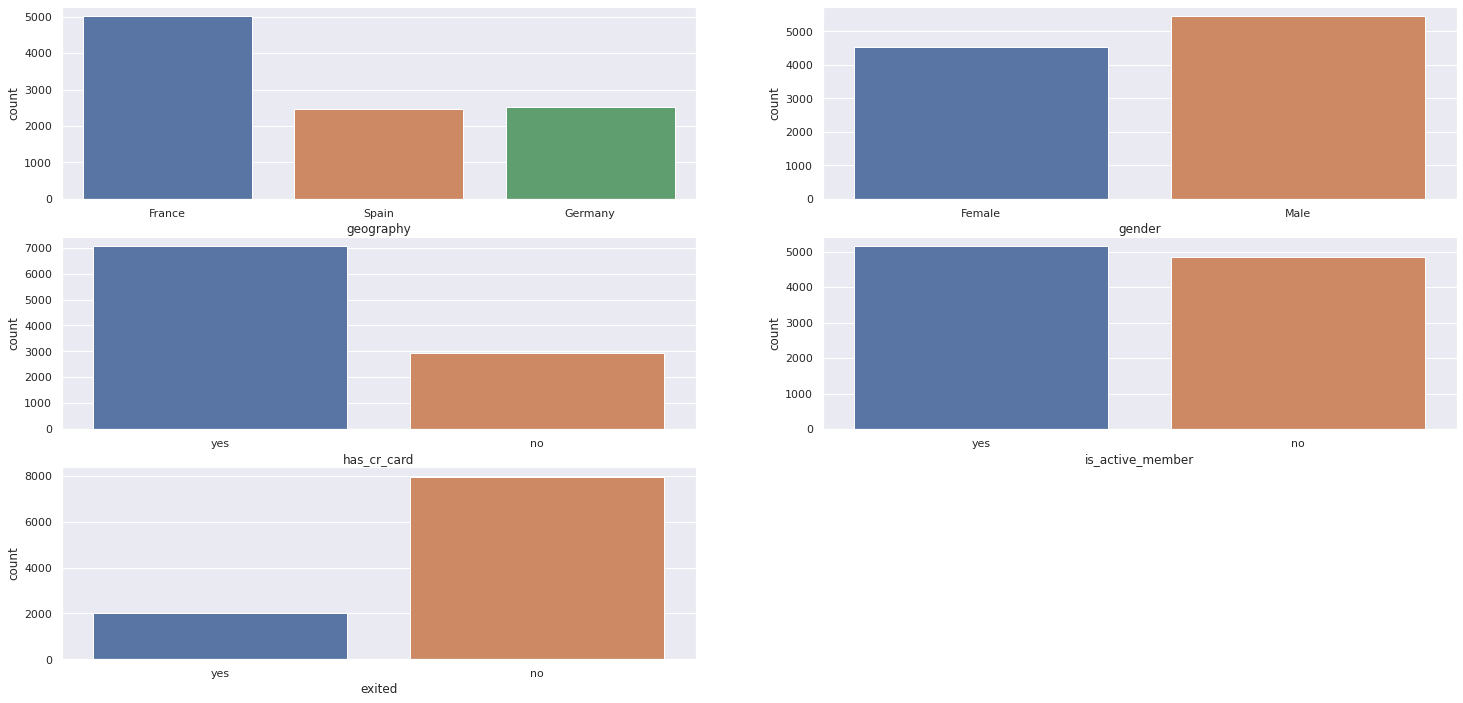

In [36]:
columns = ['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited']
j = 1

for i in columns:
    plt.subplot(3, 2, j)
    sns.countplot(x=i, data=df4);
    j += 1

## 4.2 Bivariate Analysis

### H1 Pessoas com mais tempo ativo gastam mais.

**Inconclusive:** não há diferenção entre o tempo ativo e os valores gastos.

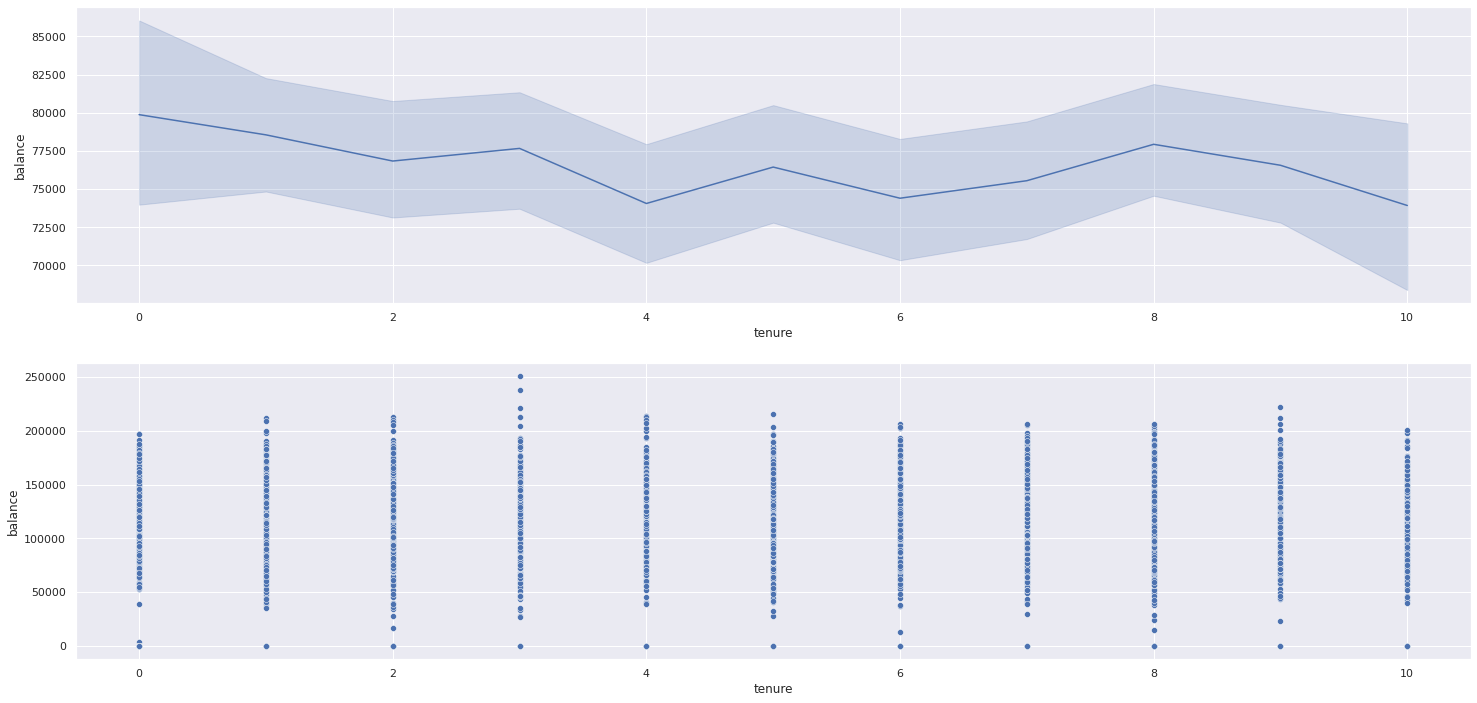

In [37]:
plt.subplot(2, 1, 1)
sns.lineplot(y='balance', x='tenure', data=df4);

plt.subplot(2, 1, 2)
sns.scatterplot(y='balance', x='tenure', data=df4);

### H2 Pessoas mais jovens entram mais em churn.

**False:** Não há mais *churns* entre as pessoas mais jovens.

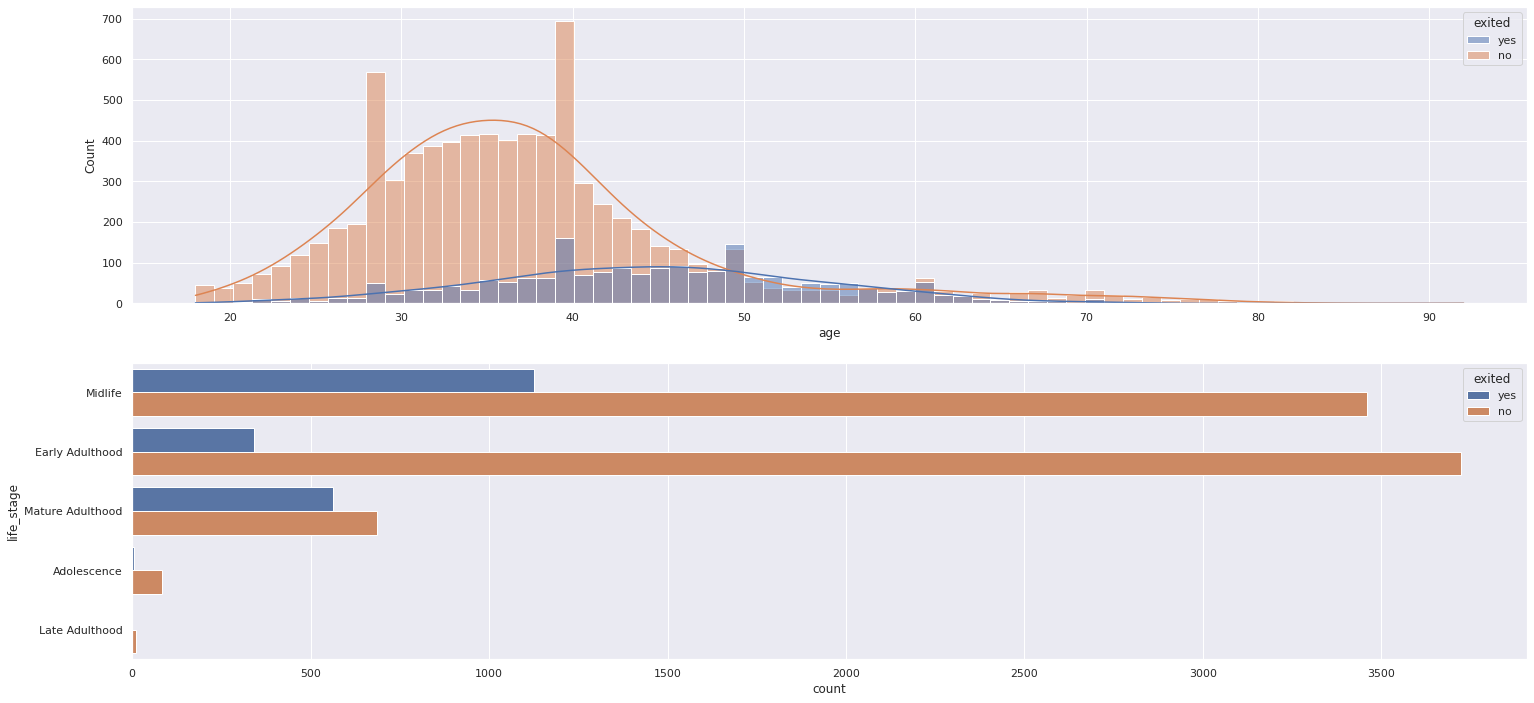

In [38]:
plt.subplot(2, 1, 1)
sns.histplot(x='age', hue='exited', kde=True, data=df4);

plt.subplot(2, 1, 2)
sns.countplot(y='life_stage', hue='exited', data=df4);

### H4 Pessoas com menos crédito entram mais em *churn*.

**Inconclusive:** Não há diferença entre clientes com mais e menos crédito que entram em *churn*.

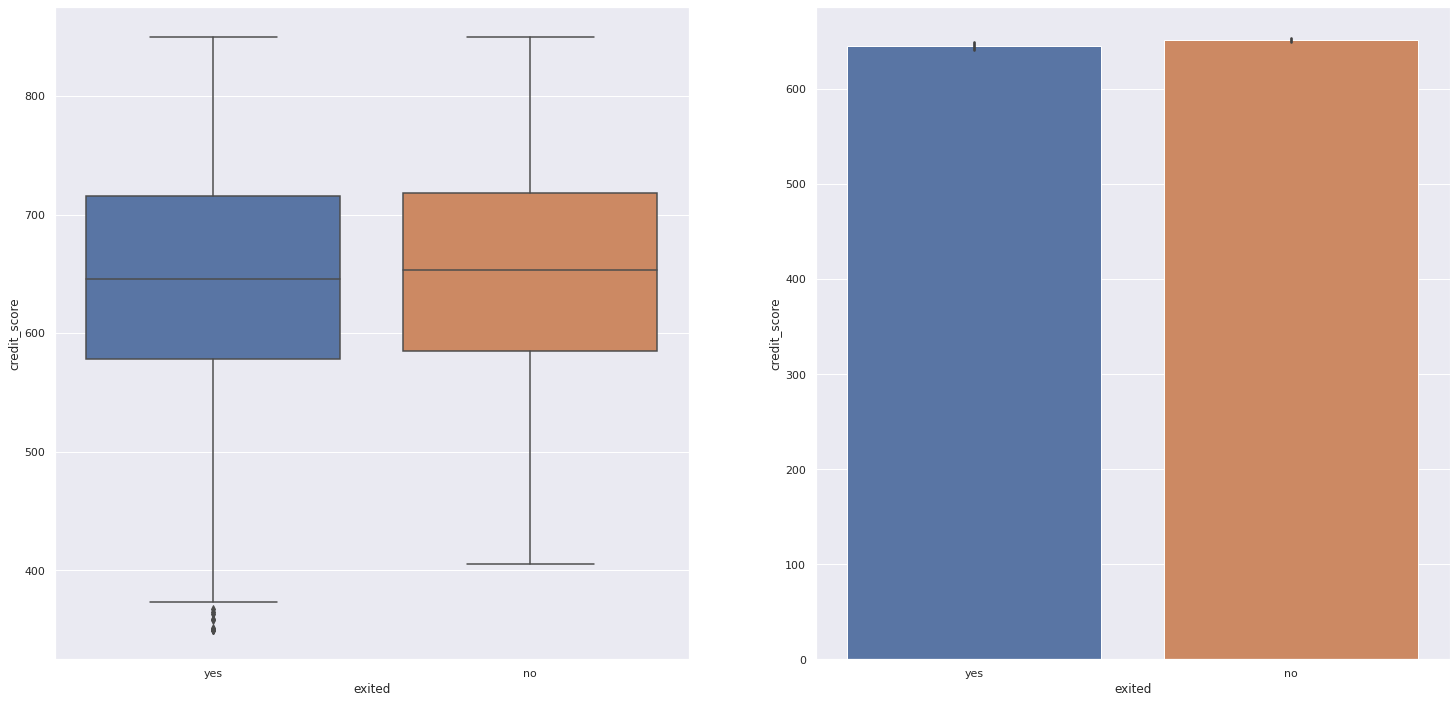

In [39]:
plt.subplot(1, 2, 1)
sns.boxplot(x='exited', y='credit_score', data=df4);

plt.subplot(1, 2, 2)
sns.barplot(x='exited', y='credit_score', data=df4);

### H5 Pessoas que moram em países mais ricos entram menos em churn.

**True:** Países que estão melhores colocadas no rank de renda per capita entram menos em churn.

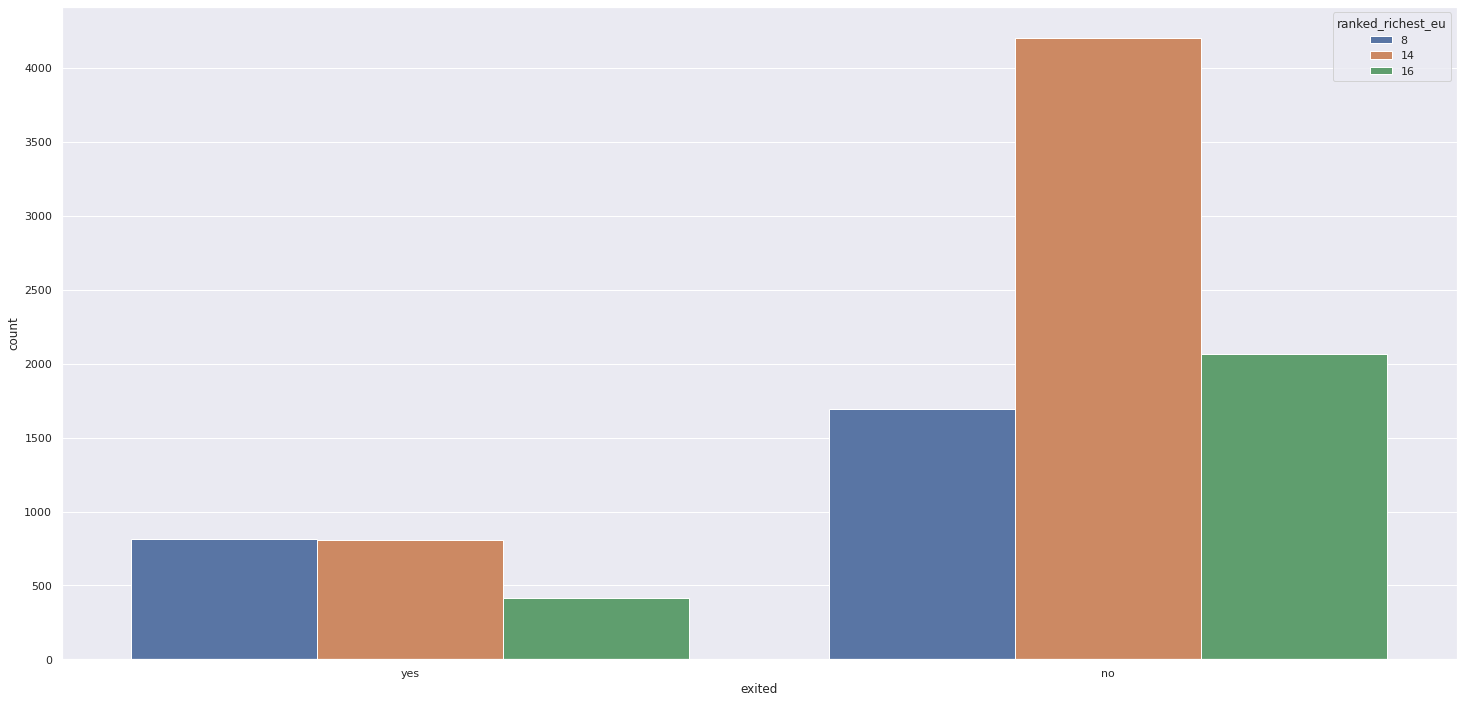

In [40]:
sns.countplot(x='exited', hue='ranked_richest_eu', data=df4);

### H6 Pessoam que gastam menos entram em churn.

**False:** Pessoas que gastam mais entram mais em *churn*. 

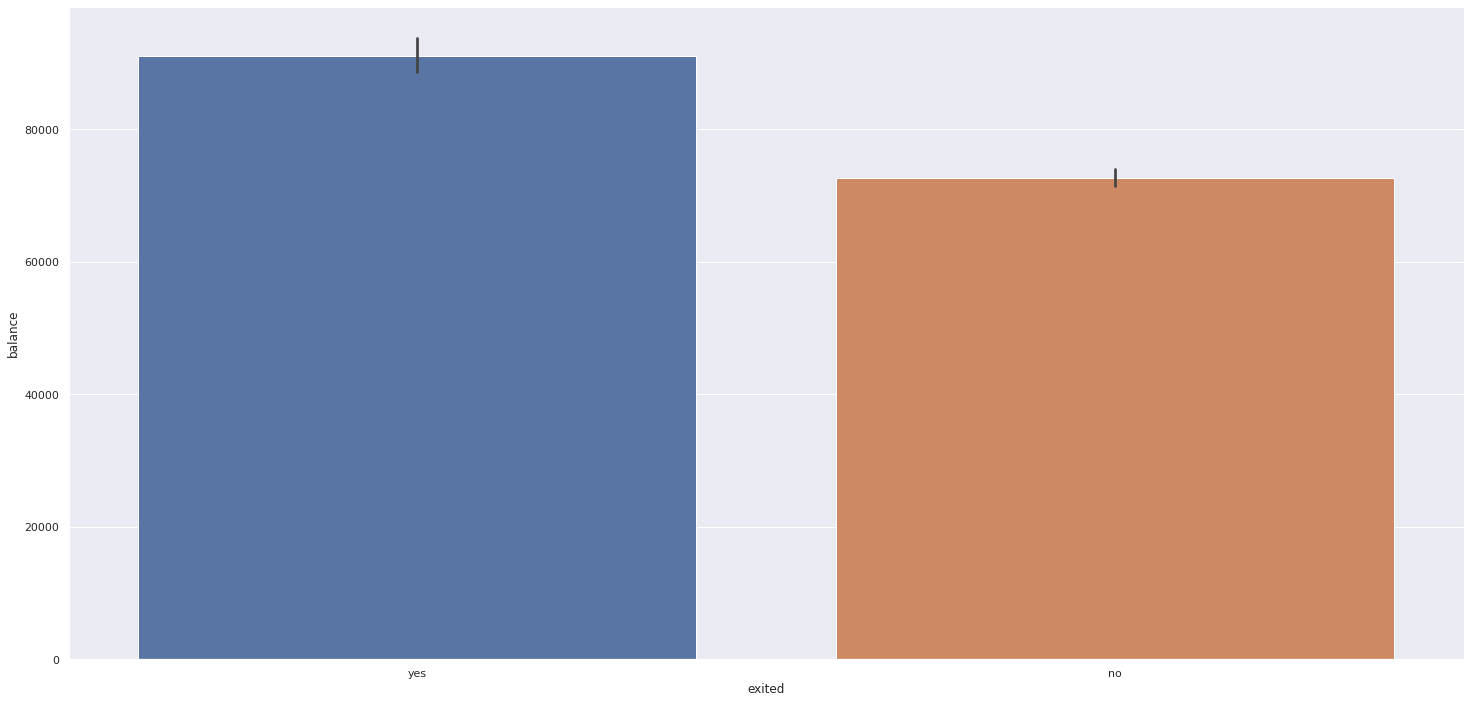

In [41]:
sns.barplot(x='exited', y='balance', data=df4);

### H7 Pessoas com cartão de crédito gastam mais com a empresa.

**Inconclusive:** Não há uma diferença significativa de gastos entre pessoas que possuem ou não cartão de crédito. 

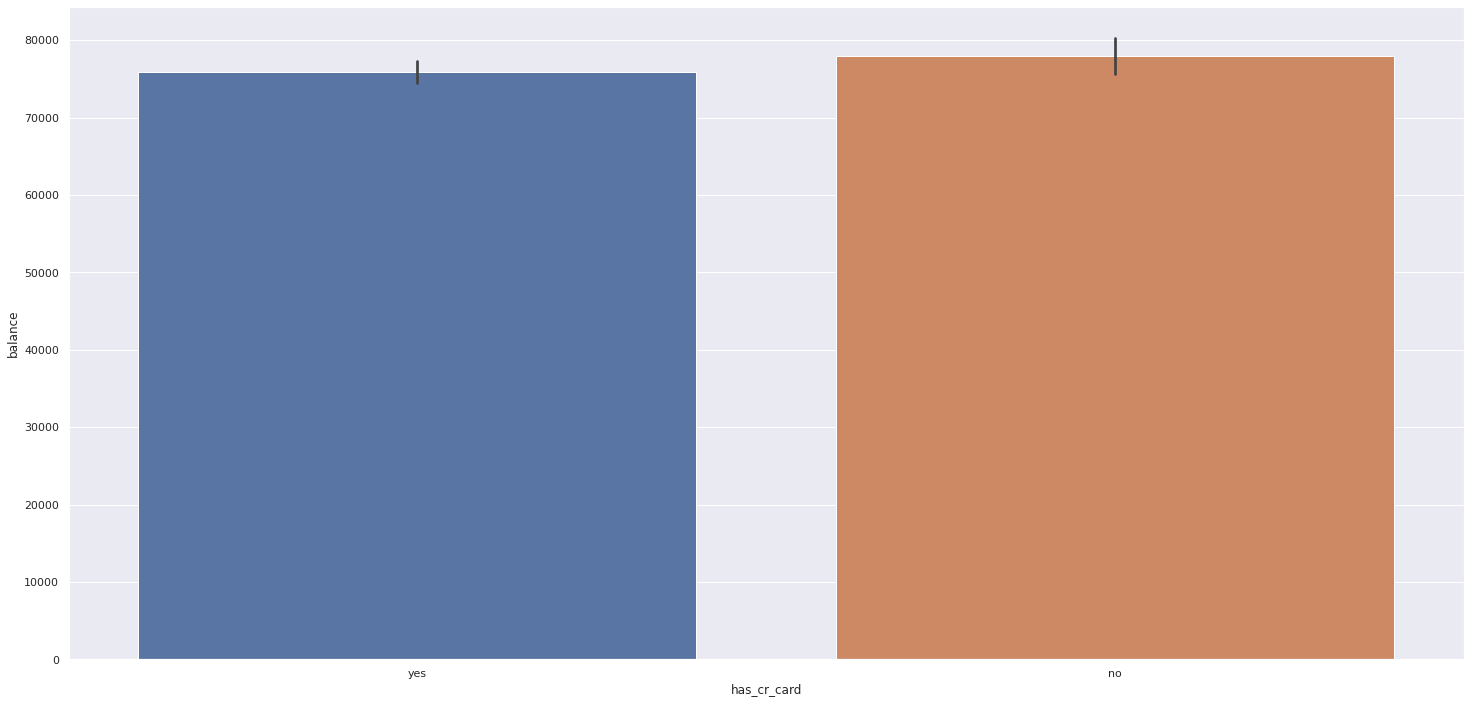

In [42]:
sns.barplot(x='has_cr_card', y='balance', data=df4);

### H8 Clientes com cartão de crédito são mais ativos.

**True:** Membros com cartão de crédito são um pouco mais ativos do que aqueles que não têm.

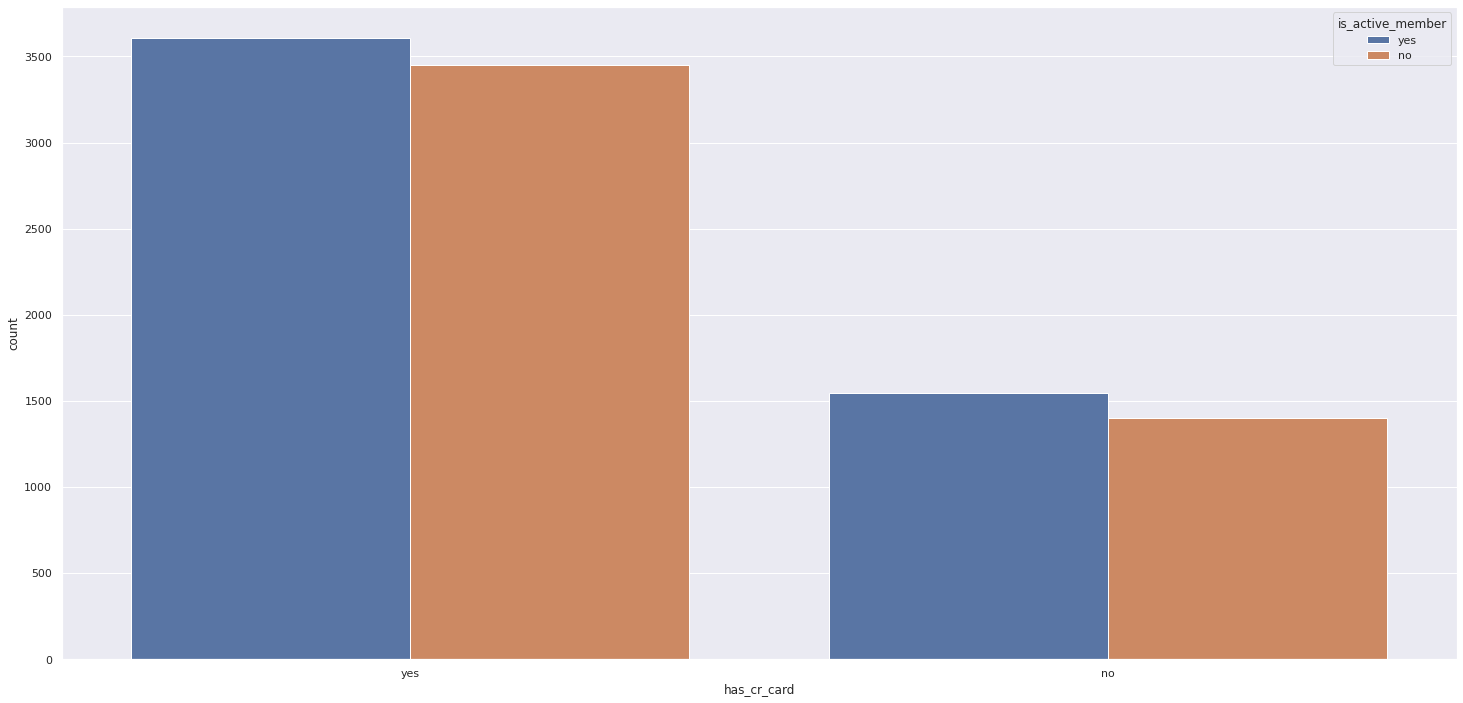

In [43]:
sns.countplot(x='has_cr_card', hue='is_active_member', data=df4);

### H9 Pessoas com maiores salários gastam mais.

**False:** Não há relação entre pessoas com os maiores salários e que gastam mais.

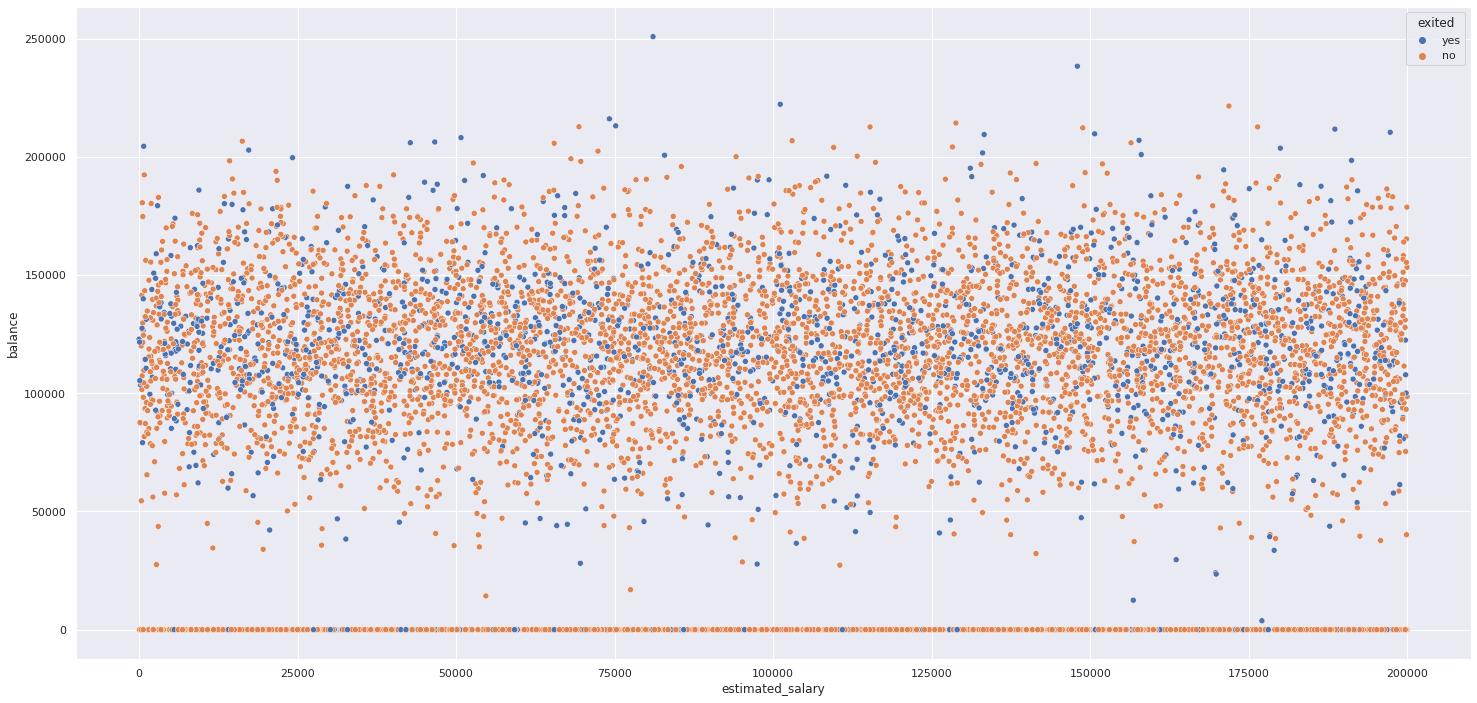

In [44]:
sns.scatterplot(x='estimated_salary', y='balance', hue='exited', data=df4);

### H10 Pessoas com maiores salários são mais ativos

**Inconclusive:** Não há uma diferença significativa entre pessoas ativas com maiores ou menores salários.

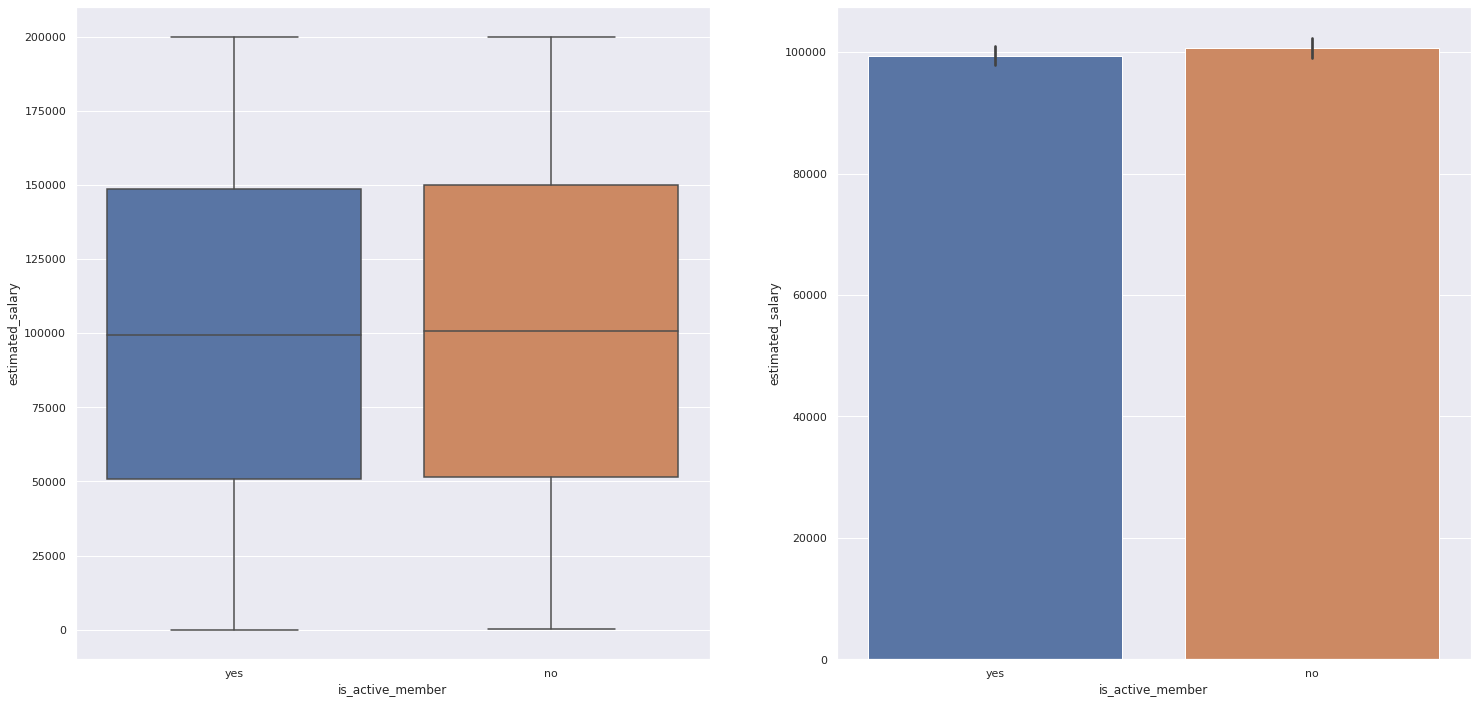

In [45]:
plt.subplot(1, 2, 1)
sns.boxplot(x='is_active_member', y='estimated_salary', data=df4);

plt.subplot(1, 2, 2)
sns.barplot(x='is_active_member', y='estimated_salary', data=df4);

### H11 Pessoas com mais crédito compram mais

**False:** Pessoas com mais crédito não gastam mais.

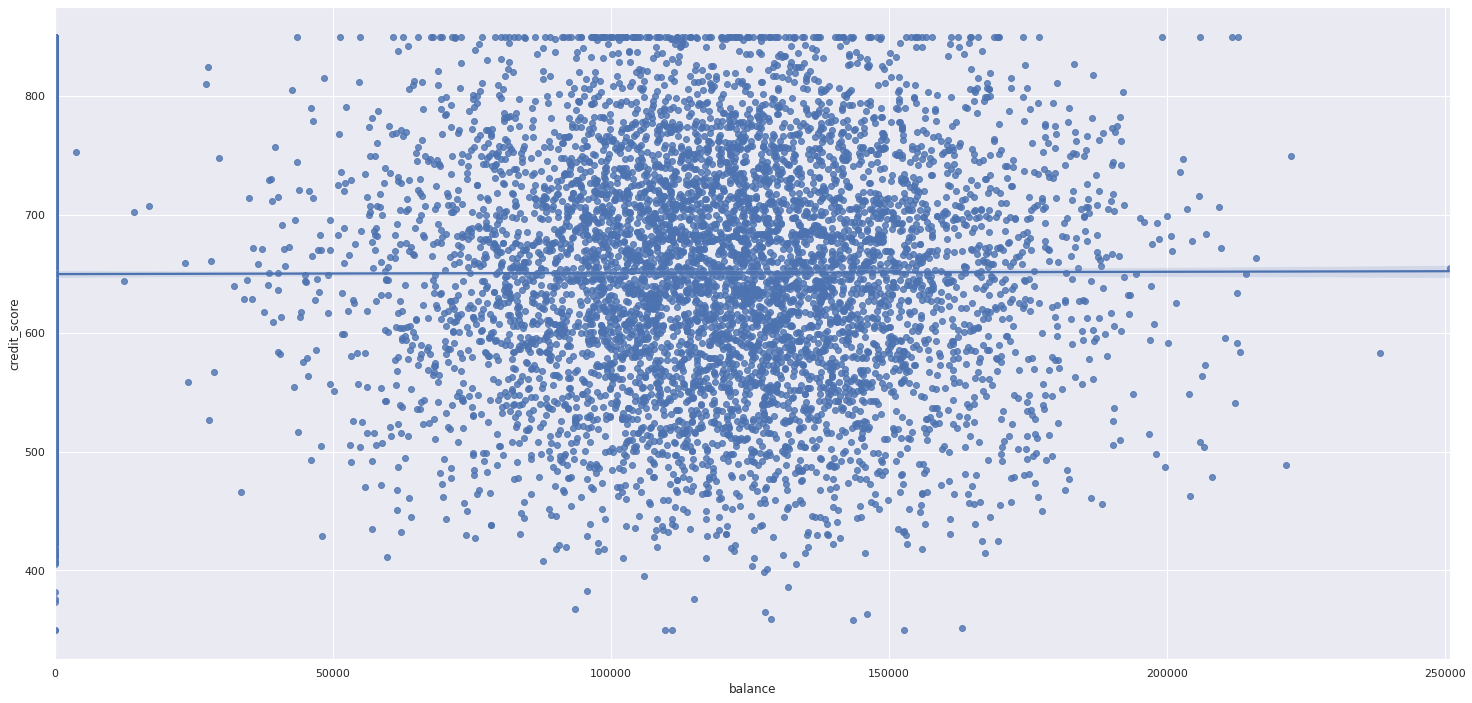

In [46]:
sns.regplot(x='balance', y='credit_score', data=df4);

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

In [47]:
aux1 = df4.select_dtypes(exclude='object')
corr = aux1.corr()

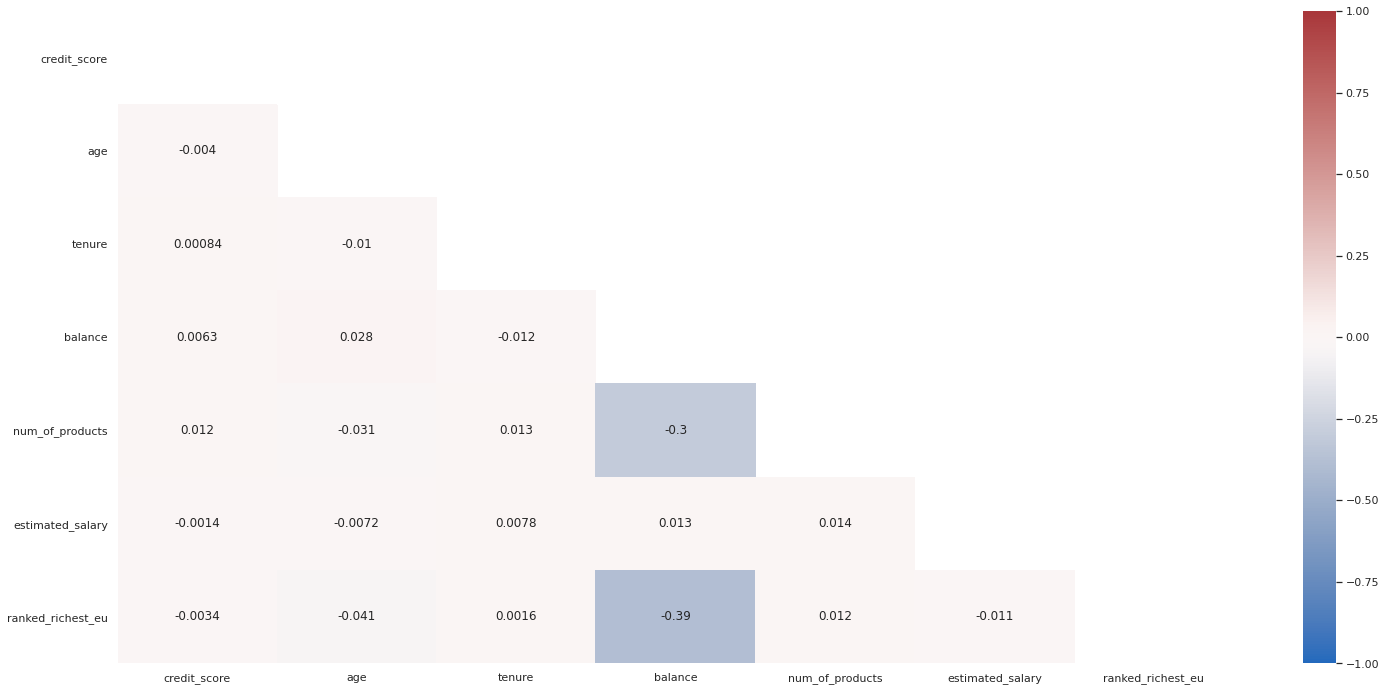

In [48]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots()
    ax = sns.heatmap(corr, annot=True, vmax=1, vmin=-1, mask=mask, center=0, cmap="vlag");

### 4.3.2 Categorical Attributes

In [49]:
aux1 = df4.select_dtypes(include="object")

In [58]:
corr_dict = {}

for column in aux1.columns.tolist():
    corr_dict[column] = {}
    
    for column2 in aux1.columns.tolist():
        corr_dict[column][column2] = calcCramerV(aux1[column], aux1[column2])
        
corr = pd.DataFrame(corr_dict)

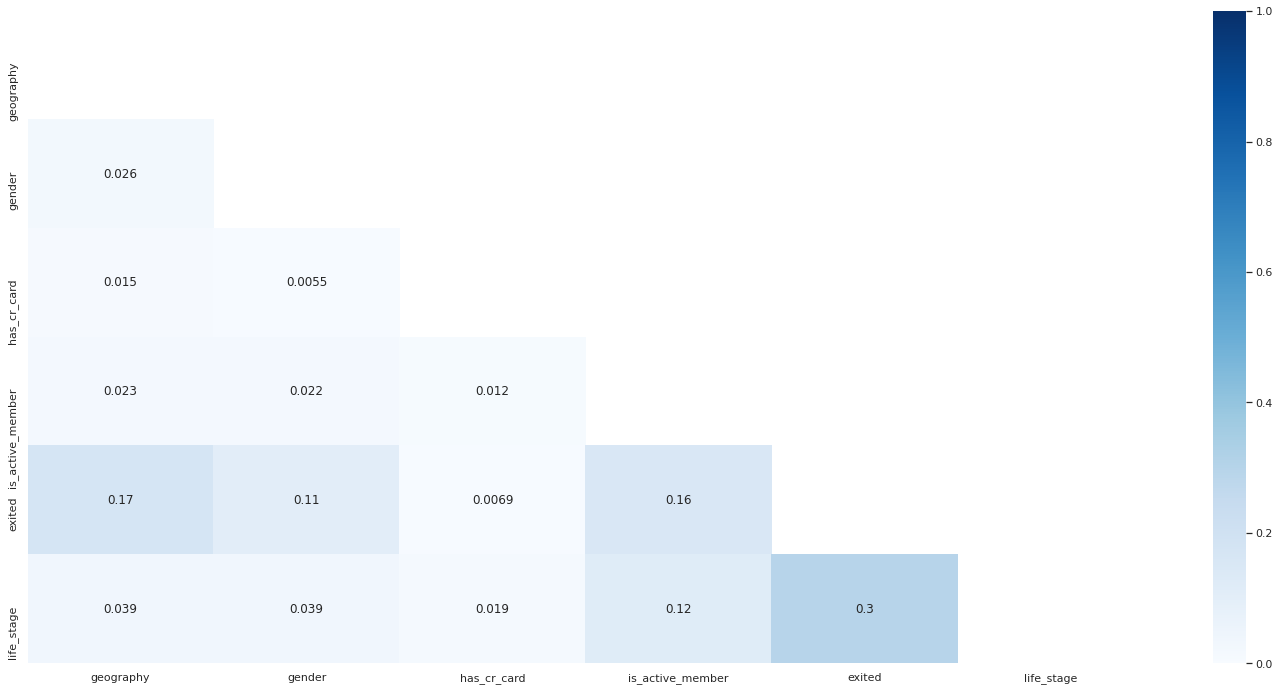

In [59]:
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    f, ax = plt.subplots()
    ax = sns.heatmap(cramerv, annot=True, vmin=0, vmax=1, mask=mask, cmap="Blues")

# 5.0 Data Preparation

In [129]:
df5 = df4.copy()

## 5.1 Spliting into Train, Valid and Test

In [130]:
X = df5.drop(columns=['exited'], axis=1)
y = df5.exited

# enconding into 0 and 1
y = y.map({'yes': 1, 'no': 0})

In [131]:
# spliting into temp and test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=.1, stratify=y)

# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.1, stratify=y_temp)

## 5.2 Target Encoder

In [132]:
target_columns = ['geography', 'gender', 'has_cr_card', 'is_active_member', 'life_stage', 'ranked_richest_eu']
target_encoder = ce.TargetEncoder(cols=target_columns)

In [133]:
X_params = target_encoder.fit_transform(X_temp, y_temp)
X_test = target_encoder.transform(X_test, y_test)

In [134]:
X_train = target_encoder.fit_transform(X_train, y_train)
X_valid = target_encoder.transform(X_valid, y_valid)

## 5.3 Scaling

In [135]:
rescaled_cols = ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']
mm = MinMaxScaler()

In [136]:
X_params[rescaled_cols] = mm.fit_transform(X_params[rescaled_cols])
X_test[rescaled_cols] = mm.transform(X_test[rescaled_cols])

In [137]:
X_train[rescaled_cols] = mm.fit_transform(X_train[rescaled_cols])
X_valid[rescaled_cols] = mm.transform(X_valid[rescaled_cols])

# 6.0 Feature Selection

## 6.1 Boruta as Feature Selector

In [138]:
X_boruto = X_params.values
y_boruto = y_temp.values.ravel()

In [139]:
boruta = BorutaPy(RandomForestClassifier(), n_estimators='auto')
boruta.fit(X_boruto, y_boruto)

BorutaPy(estimator=RandomForestClassifier(n_estimators=31,
                                          random_state=RandomState(MT19937) at 0x7F66EC055340),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7F66EC055340)

### 6.1.1 Best Features from Boruta

In [140]:
cols_selected_boruta = boruta.support_.tolist()

In [141]:
columns_selected = X_params.loc[:, cols_selected_boruta].columns.tolist()

In [142]:
columns_selected
# ['credit_score', 'age', 'balance', 'num_of_products', 'estimated_salary']

['age', 'balance', 'num_of_products', 'estimated_salary']

# 7.0 Machine Learning Modeling

In [148]:
X_train_selected = X_train[columns_selected]
X_valid_selected = X_valid[columns_selected]

X_temp_selected = X_params[columns_selected]
X_test_selected = X_test[columns_selected]

## 7.1 Baseline Model

In [149]:
dummy = DummyClassifier()
dummy.fit(X_train_selected, y_train)

y_pred = dummy.predict(X_valid_selected)

In [150]:
dummy_results = ml_scores('dummy', y_valid, y_pred)
dummy_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.509,0.216,0.23,0.223,0.017


### 7.1.1 Classification Report

In [151]:
print(m.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       717
           1       0.22      0.23      0.22       183

    accuracy                           0.67       900
   macro avg       0.51      0.51      0.51       900
weighted avg       0.68      0.67      0.68       900



### 7.1.2 Cross Validation

In [152]:
dummy_cv = ml_cv_results('dummy', DummyClassifier(), X_temp_selected, y_temp)
dummy_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
dummy,0.498 +/- 0.013,0.2 +/- 0.02,0.201 +/- 0.029,0.2 +/- 0.024,-0.005 +/- 0.026


## 7.2 Logistic Regression

In [153]:
lg = LogisticRegression()
lg.fit(X_train_selected, y_train)

y_pred = lg.predict(X_valid_selected)

In [154]:
lg_results = ml_scores('Logistic Regression', y_valid, y_pred)
lg_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.498,0.182,0.033,0.056,-0.007


### 7.2.1 Classification Report

In [155]:
print(m.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       717
           1       0.18      0.03      0.06       183

    accuracy                           0.77       900
   macro avg       0.49      0.50      0.46       900
weighted avg       0.67      0.77      0.71       900



### 7.2.2 Cross Validation

In [156]:
lg_cv = ml_cv_results('Logistic Regression', LogisticRegression(), X_temp_selected, y_temp)
lg_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.509 +/- 0.003,0.278 +/- 0.029,0.052 +/- 0.005,0.087 +/- 0.009,0.025 +/- 0.009


## 7.3 K Nearest Neighbors

In [157]:
knn = KNeighborsClassifier()
knn.fit(X_train_selected, y_train)

y_pred = knn.predict(X_valid_selected)

In [158]:
knn_results = ml_scores('K Nearest Neighbors', y_valid, y_pred)
knn_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.676,0.623,0.415,0.498,0.401


### 7.3.1 Classification Report

In [159]:
print(m.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       717
           1       0.62      0.42      0.50       183

    accuracy                           0.83       900
   macro avg       0.74      0.68      0.70       900
weighted avg       0.81      0.83      0.82       900



### 7.3.1 Cross Validation

In [160]:
knn_cv = ml_cv_results('K Nearest Neighbors', KNeighborsClassifier(), X_temp_selected, y_temp)
knn_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
K Nearest Neighbors,0.664 +/- 0.008,0.591 +/- 0.022,0.399 +/- 0.017,0.476 +/- 0.015,0.373 +/- 0.018


## 7.4 Support Vector Machine

In [161]:
svm = SVC()
svm.fit(X_train_selected, y_train)

y_pred = svm.predict(X_valid_selected)

In [162]:
svm_results = ml_scores('SVM', y_valid, y_pred)
svm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.561,0.774,0.131,0.224,0.176


### 7.4.1 Classification Support

In [163]:
print(m.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.99      0.90       717
           1       0.77      0.13      0.22       183

    accuracy                           0.82       900
   macro avg       0.80      0.56      0.56       900
weighted avg       0.81      0.82      0.76       900



### 7.4.2 Cross Validation

In [164]:
svm_cv = ml_cv_results('SVM', SVC(), X_temp_selected, y_temp)
svm_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.59 +/- 0.012,0.784 +/- 0.043,0.194 +/- 0.025,0.31 +/- 0.033,0.25 +/- 0.029


## 7.5 Random Forest

In [165]:
rf = RandomForestClassifier()
rf.fit(X_train_selected, y_train)

y_pred = rf.predict(X_valid_selected)

In [166]:
rf_results = ml_scores('Random Forest', y_valid, y_pred)
rf_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.66,0.576,0.393,0.468,0.362


### 7.5.1 Classification Support

In [167]:
print(m.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       717
           1       0.58      0.39      0.47       183

    accuracy                           0.82       900
   macro avg       0.72      0.66      0.68       900
weighted avg       0.80      0.82      0.80       900



### 7.5.2 Cross Validation

In [168]:
rf_cv = ml_cv_results('Random Forest', RandomForestClassifier(), X_temp_selected, y_temp)
rf_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
Random Forest,0.669 +/- 0.01,0.586 +/- 0.019,0.411 +/- 0.021,0.483 +/- 0.019,0.379 +/- 0.021


## 7.6 XGBoost

In [169]:
xgb = XGBClassifier()
xgb.fit(X_train_selected, y_train)

y_pred = xgb.predict(X_valid_selected)

In [170]:
xgb_results = ml_scores('XGBoost', y_valid, y_pred)
xgb_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.655,0.607,0.372,0.461,0.363


### 7.6.1 Classification Report

In [171]:
print(m.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       717
           1       0.61      0.37      0.46       183

    accuracy                           0.82       900
   macro avg       0.73      0.66      0.68       900
weighted avg       0.80      0.82      0.81       900



### 7.6.2 Cross Validation

In [172]:
xgb_cv = ml_cv_results('XGBoost', XGBClassifier(), X_temp_selected, y_temp)
xgb_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.67 +/- 0.011,0.62 +/- 0.018,0.403 +/- 0.023,0.488 +/- 0.019,0.391 +/- 0.021


## 7.7 LightGBM

In [173]:
lgbm = LGBMClassifier()
lgbm.fit(X_train_selected, y_train)

y_pred = xgb.predict(X_valid_selected)

In [174]:
lgbm_results = ml_scores('LightGBM', y_valid, y_pred)
lgbm_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.655,0.607,0.372,0.461,0.363


### 7.7.1 Classification Report

In [175]:
print(m.classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.89       717
           1       0.61      0.37      0.46       183

    accuracy                           0.82       900
   macro avg       0.73      0.66      0.68       900
weighted avg       0.80      0.82      0.81       900



### 7.7.2 Cross Validation

In [176]:
lgbm_cv = ml_cv_results('LightGBM', LGBMClassifier(), X_temp_selected, y_temp)
lgbm_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
LightGBM,0.68 +/- 0.012,0.663 +/- 0.024,0.414 +/- 0.023,0.509 +/- 0.022,0.418 +/- 0.025


## 7.8 Comparing Model's Performance

### 7.7.1 Single Performance

In [177]:
modeling_performance = pd.concat([dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, lgbm_results])
modeling_performance.sort_values(by="Recall", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.498,0.182,0.033,0.056,-0.007
dummy,0.509,0.216,0.230,0.223,0.017
XGBoost,0.655,0.607,0.372,0.461,0.363
LightGBM,0.655,0.607,0.372,0.461,0.363
Random Forest,0.660,0.576,0.393,0.468,0.362
K Nearest Neighbors,0.676,0.623,0.415,0.498,0.401


### 7.7.2 Cross Validation Peformance

In [178]:
modeling_performance_cv = pd.concat([dummy_cv, lg_cv, knn_cv, 
                                     rf_cv, xgb_cv, lgbm_cv])
modeling_performance_cv.sort_values(by="Recall", ascending=True)

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.509 +/- 0.003,0.278 +/- 0.029,0.052 +/- 0.005,0.087 +/- 0.009,0.025 +/- 0.009
dummy,0.498 +/- 0.013,0.2 +/- 0.02,0.201 +/- 0.029,0.2 +/- 0.024,-0.005 +/- 0.026
K Nearest Neighbors,0.664 +/- 0.008,0.591 +/- 0.022,0.399 +/- 0.017,0.476 +/- 0.015,0.373 +/- 0.018
XGBoost,0.67 +/- 0.011,0.62 +/- 0.018,0.403 +/- 0.023,0.488 +/- 0.019,0.391 +/- 0.021
Random Forest,0.669 +/- 0.01,0.586 +/- 0.019,0.411 +/- 0.021,0.483 +/- 0.019,0.379 +/- 0.021
LightGBM,0.68 +/- 0.012,0.663 +/- 0.024,0.414 +/- 0.023,0.509 +/- 0.022,0.418 +/- 0.025


# 8.0 Hyperparameter Fine Tuning

## 8.1 Grid Search

In [179]:
recall = m.make_scorer(m.recall_score)

In [180]:
params = {
    'eta': [0.001, 0.01, 0.1, 0.3],
    'scale_pos_weight': [1, 4]
}

X_params_selected = X_params[columns_selected]

In [181]:
gs = GridSearchCV(XGBClassifier(), 
                  param_grid=params, 
                  scoring=recall, 
                  cv=5, return_train_score=True)

gs.fit(X_params_selected, y_temp)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [182]:
best_params = gs.best_params_
best_params

# {'eta': 0.001, 'scale_pos_weight': 4}

{'eta': 0.001, 'scale_pos_weight': 4}

In [183]:
gs.best_score_

# 0.7375843123241167

0.7130626405205402

## 8.2 Results

In [184]:
xgb_gs = XGBClassifier(
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

In [185]:
xgb_gs.fit(X_train_selected, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.001, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00100000005, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [186]:
y_pred = xgb_gs.predict(X_valid_selected)

### 8.2.1 Single Result

In [187]:
xgb_gs_results = ml_scores('XGBoost GS', y_valid, y_pred)
xgb_gs_results

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost GS,0.756,0.473,0.716,0.57,0.43


### 8.2.2 Cross Validation

In [188]:
xgb_gs_cv = ml_cv_results('XGBoost', XGBClassifier(
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight'],
    random_state=42
), X_temp_selected, y_temp)

xgb_gs_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGBoost,0.75 +/- 0.012,0.451 +/- 0.007,0.726 +/- 0.031,0.556 +/- 0.012,0.407 +/- 0.015


# 9.0 Conclusions

## 9.1 Final Model

In [189]:
final_model = XGBClassifier(
    eta=best_params['eta'],
    scale_pos_weight=best_params['scale_pos_weight']
)

final_model.fit(X_params_selected, y_temp)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.001, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.00100000005, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### 9.1.1 Unseen Data Score

In [190]:
y_pred_final = final_model.predict(X_test_selected)

ml_scores('unseen', y_test, y_pred_final)

,Balanced Accuracy,Precision,Recall,F1,Kappa
unseen,0.763,0.469,0.74,0.574,0.432


## 9.2 Business Questions

### 9.2.1 Qual a taxa atual de Churn da TopBank?

In [191]:
aux1 = df2['exited'].value_counts().reset_index()
churn_year_rate = aux1[aux1['index'] == 'yes']['exited'].sum() / (aux1['exited'].sum()) * 100

In [192]:
print('A taxa atual de Churn do banco é {:.2f}%.'.format(churn_year_rate))

A taxa atual de Churn do banco é 20.37%.


### 9.2.2 Como ela varia mensalmente?

In [193]:
aux2 = df2['is_active_member'].value_counts().reset_index()

churn_year_rate = aux2[aux2['index'] == 'yes']['is_active_member'].sum() / aux2['is_active_member'].sum() * 100
churn_month_rate = churn_year_rate / 12

In [194]:
print('A taxa mensal de Churn do banco é de {:.2f}%.'.format(churn_month_rate))

A taxa mensal de Churn do banco é de 4.29%.


### 9.2.3 Qual o retorno esperado, em termos de faturamento, se a empresa utilizar seu modelo para evitar o churn dos clientes?

In [195]:
df9 = pd.concat([X, y], join='outer', axis=1)

In [196]:
aux9 = df9.loc[X_test.index, :]
aux9['pred_exited'] = y_pred_final

In [197]:
salary_mean = df9['estimated_salary'].mean()

In [198]:
exited_total = aux9[aux9['exited'] == 1]['estimated_salary'].apply(lambda x: 0.15*x if x <= salary_mean else 0.20*x)

exited_redeemed = aux9[(aux9['exited'] == 1) & (aux9['pred_exited'] == 1)]['estimated_salary'].apply(lambda x: 0.15*x if x <= salary_mean else 0.20*x)

In [199]:
print('Para a base teste recuperou-se %.2f em relação a %.2f.' % (exited_redeemed.sum(), exited_total.sum()))
print('Aproximadamente %.2f das perdas recuperadas.' % ((exited_redeemed.sum() / exited_total.sum())))

Para a base teste recuperou-se 3039285.31 em relação a 4060495.27.
Aproximadamente 0.75 das perdas recuperadas.


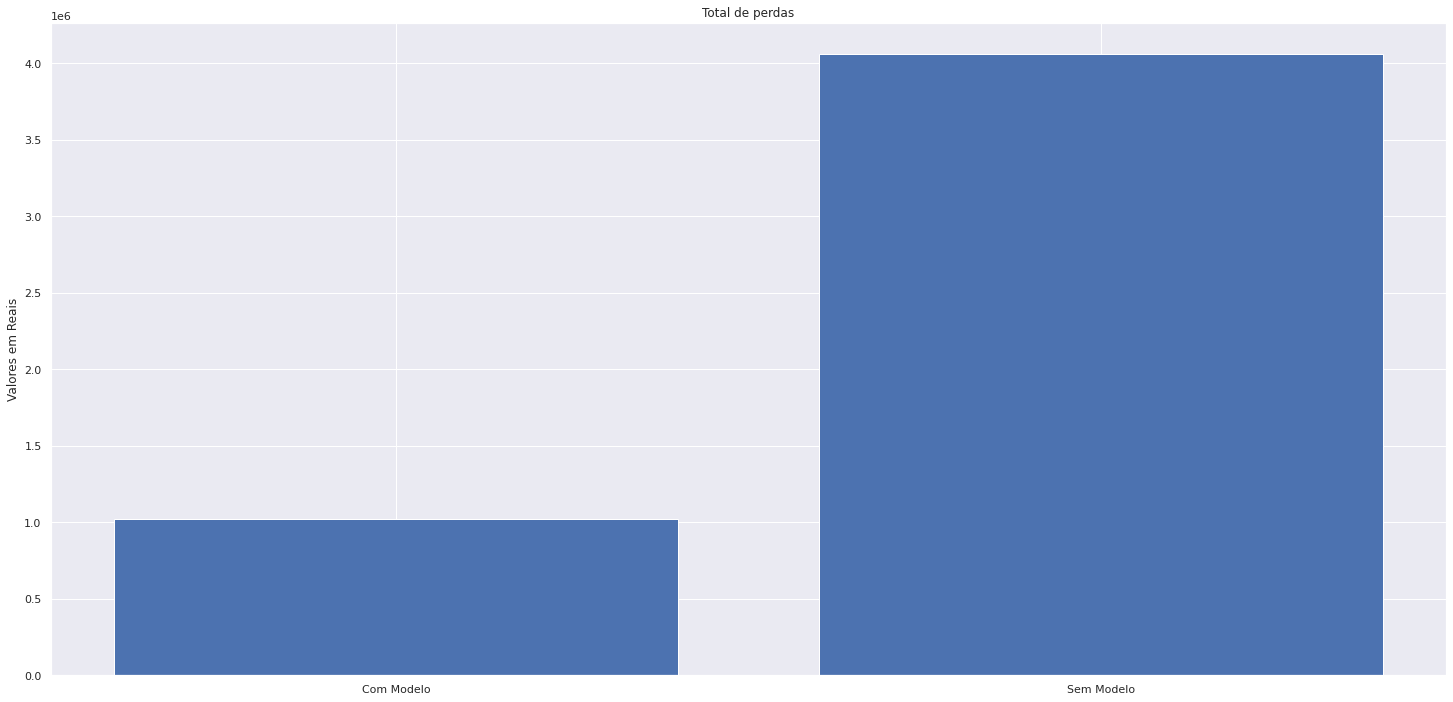

In [200]:
y = [exited_total.sum() - exited_redeemed.sum(), exited_total.sum()]
x = ['Com Modelo', 'Sem Modelo']

plt.bar(x, y)
plt.title('Total de perdas')
plt.ylabel('Valores em Reais')
plt.show()

### 9.2.4 A taxa de Churns com a implementação do modelo.

In [201]:
print('A taxa de churn cairá para %.2f.' % (0.25))

A taxa de churn cairá para 0.25.


# 10.0 Model Deploy